In [ ]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt

# To plot the map
import cartopy.crs as ccrs

# To perform the ML technics using sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# 1. One-month prediction

In [28]:
# Get the data for a 1-month prediction, split and scale the data

X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

### 1.1 First evaluation

In [29]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

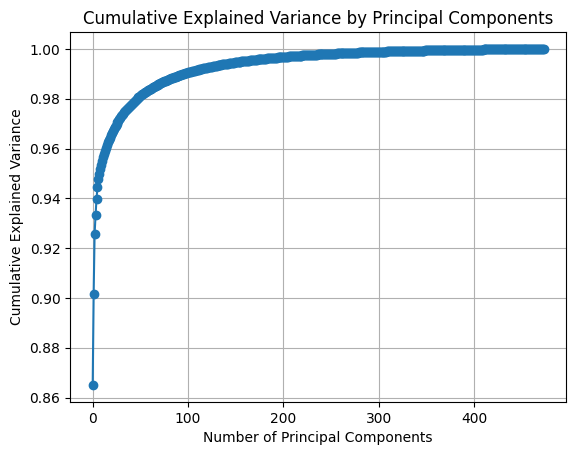

In [30]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [60]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))


In [61]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 55
Train Score for the best p: 0.9358288770053476
Test Score for the best p: 0.92
Amélioration tu score de test: + 0.06


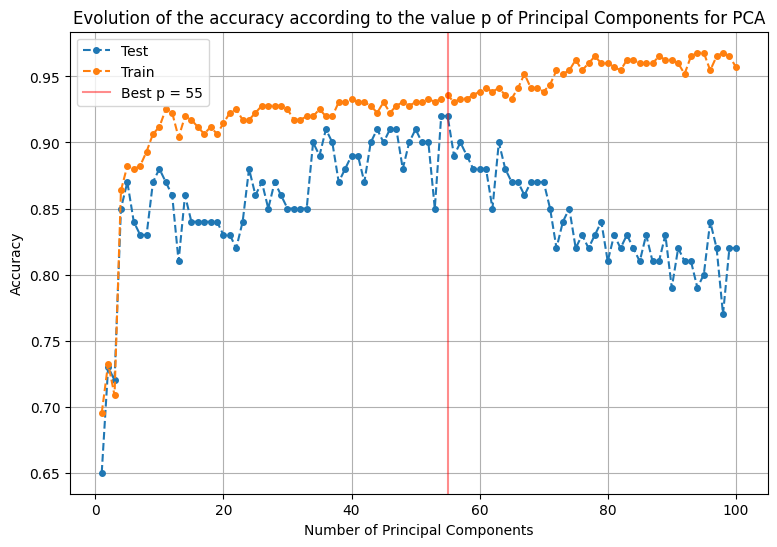

In [62]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

## 1.2. Baseline n°2 - OLS

In [ ]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression